# 驾驶员状态检测

根据汽车安全部门的调查显示，五分之一的交通事故都是由于驾驶员分心(distracted)造成的。每年，distracted driving会造成约42500人受伤，3000人死亡。这个数字非常惊人。

[State Farm](https://www.statefarm.com/)希望通过车载的dashboard cameras来检测用户是否处于distracted driving的状态，从而发出警告。

</br>
<font color=red size=3 face=“黑体”>这是我实际的开发过程，我不会上来就写出最优的解决方案，而是把我所遇到的“坑”都给写出来，这些“坑”真的很经典</font>

## 1.1 数据集获取

[数据集](https://www.kaggle.com/c/state-farm-distracted-driver-detection/data)来自于kaggle，总共有三个文件需要下载，如下所示。其中imgs.zip是通过摄像头来抓取的驾驶员的状态的标记数据集。该数据集的大小有4G。

* imgs.zip - 所有训练/测试图片打包的zip文件<font color=red size=3 face=“黑体”>(你需要自行下载)</font>
* sample_submission.csv - 提交kaggle时候的格式
* driver_imgs_list.csv - 文件的信息，文件名对应的图像中的司机ID以及图像中司机的状态ID。

现在解压imgs.zip来观察


In [11]:
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile
import os
import h5py
import numpy as np

zip_name = 'imgs.zip'
train_dir_name = 'train'
test_dir_name = 'test'

resnet_50_model_save_name = 'model_resnet50.h5'
inceptionv3_model_save_name = 'model_inceptionv3.h5'
xception_model_save_name = 'model_xception.h5'

## check if the train and  test data is exist
if not isdir(train_dir_name) or not isdir(test_dir_name):
    if not isfile(zip_name):
        print ("Please download imgs.zip from kaggle!")
        assert(False)
    else:
        with zipfile.ZipFile(zip_name) as azip:
            print ("Now to extract %s " % (zip_name))
            azip.extractall()
print ("Data is ready!")

Data is ready!


我们将检测驾驶员10种驾驶员的驾驶状态，如下

* c0: 安全驾驶
* c1: 右手打字
* c2: 右手打电话
* c3: 左手打字
* c4: 左手打电话
* c5: 调收音机
* c6: 喝饮料
* c7: 拿后面的东西
* c8: 整理头发和化妆
* c9: 和其他乘客说话

其中，关于每一种驾驶状态的图片都分开存放，也就是有c0-c9文件夹存放各自状态的图片。此时文件夹的目录结构大概如下

|----imgs.zip  
|----train  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-----c0  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-----c1  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-----c2  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-----c3  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-----c4  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-----c5  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-----c6  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-----c7  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-----c8  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|-----c9  
|----test  


### 1.2 数据集基本信息

接下来就是了解数据集的基本信息：

1. 统计训练测试样本数量
2. 每一类训练数据的数量分布


In [12]:
import os

## get train and file nums
train_class_dir_names = os.listdir(train_dir_name)
test_size = len(os.listdir(test_dir_name))

train_size = 0
train_class_size = {}

for dname in train_class_dir_names:
    file_names = os.listdir(train_dir_name + '/' + dname)
    train_class_size[dname] = len(file_names)
    train_size = train_class_size[dname] + train_size
    
print ("Test file numbers: ", test_size)
print ("Train file numbers: ", train_size)

Test file numbers:  79726
Train file numbers:  22424


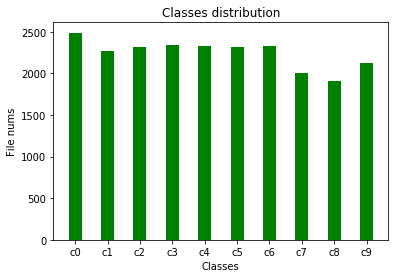

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()  
plt.bar(train_class_size.keys(), train_class_size.values(), 0.4, color="green")  
plt.xlabel("Classes")  
plt.ylabel("File nums")  
plt.title("Classes distribution")  
plt.show()

从上面的结果可以看出，我们总共有79726张测试图片，22424张测试图片。在训练图片中，每一个状态（类）包含大约2000张图片，分布还是比较均匀的。上面的可视化是根据状态来显示的，现在我们从另一个角度，看看每个司机大约包含了多少张图片。

接下来就要解压文件driver_imgs_list.csv.zip

In [15]:
# get driver_imgs_list_file
driver_imgs_list_zip = 'driver_imgs_list.csv.zip'
driver_imgs_list_file = 'driver_imgs_list.csv'

if not isfile(driver_imgs_list_file):
    if not isfile(driver_imgs_list_zip):
        print ("Please download river_imgs_list.csv.zip from kaggle!")
        assert(False)
    else:
        with zipfile.ZipFile(driver_imgs_list_zip) as azip:
            print ("Now to extract %s " % (driver_imgs_list_zip))
            azip.extractall()

Now to extract driver_imgs_list.csv.zip 


In [21]:
import pandas as pd

df = pd.read_csv(driver_imgs_list_file)

df.describe()

,subject,classname,img
count,22424,22424,22424
unique,26,10,22424
top,p021,c0,img_41079.jpg
freq,1237,2489,1


p021    1237
p022    1233
p024    1226
p026    1196
p016    1078
p066    1034
p049    1011
p051     920
p014     876
p015     875
p035     848
p047     835
p081     823
p012     823
p064     820
p075     814
p061     809
p056     794
p050     790
p052     740
p002     725
p045     724
p039     651
p041     605
p042     591
p072     346
Name: subject, dtype: int64


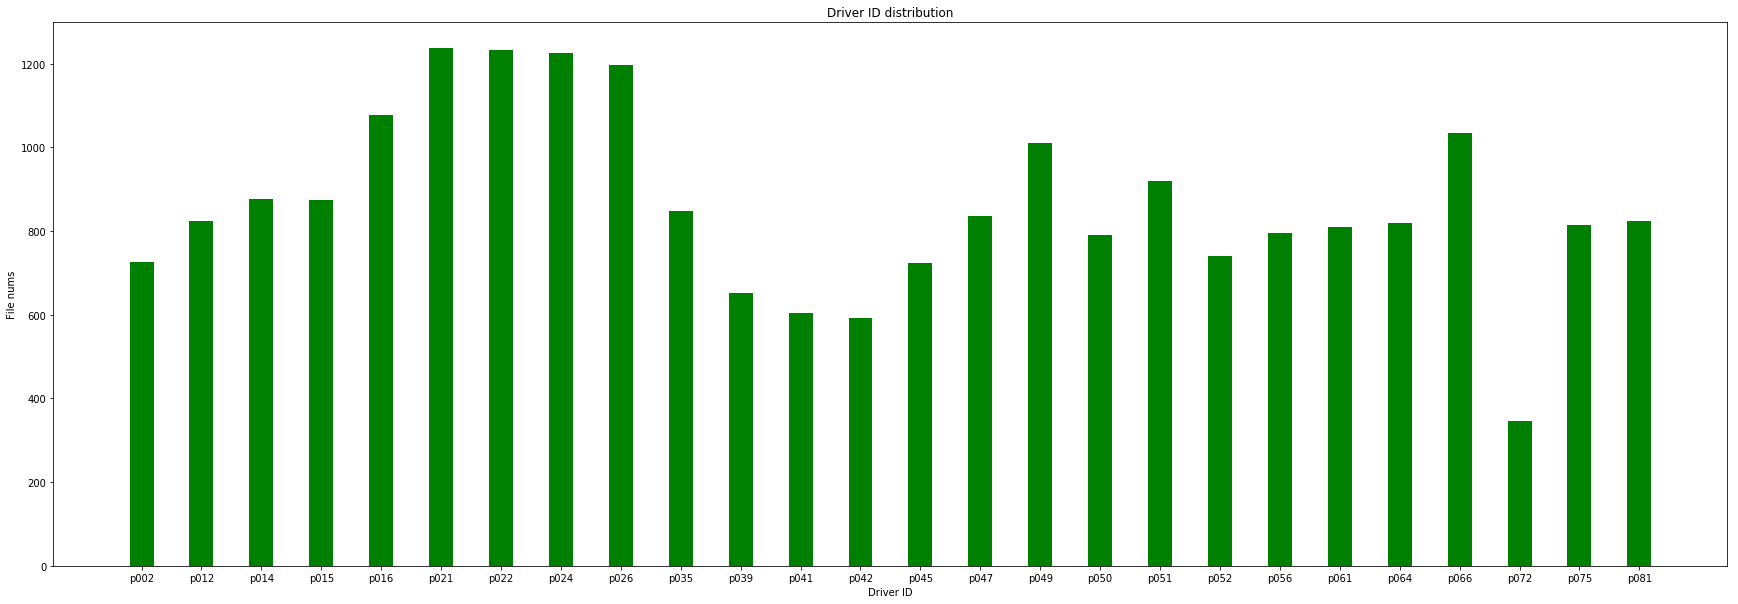

In [55]:
ts = df['subject'].value_counts()
print (ts)
fig = plt.figure(figsize=(30,10))  
plt.bar(ts.index.tolist(), ts.iloc[:].tolist(), 0.4, color="green")  
plt.xlabel("Driver ID")  
plt.ylabel("File nums")  
plt.title("Driver ID distribution")
plt.show()


可以看出，我们的训练集的数据来自于26个不同的司机的状态，每个司机都是都拥有不同状态的图片，其中346号司机拥有的图片数量最少，为346张。21号司机拥有的图片数量最多，为1237张。可以看出，如果按照司机ID来观察数据，数据分布并不均匀。但是这并不影响我们的训练，因为我们主要关心的是每一个状态所拥有的图片是否均匀，而不是每一个司机所拥有的图片是否均匀。接下来我们来简单可视化一下每一类的样本

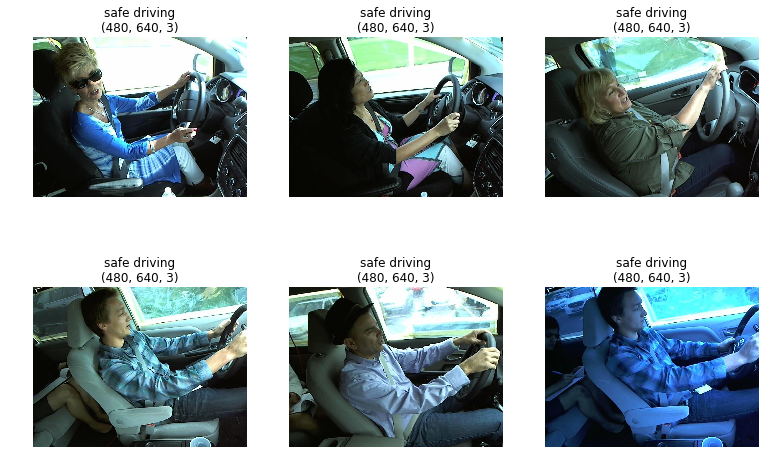

In [100]:
import cv2
import numpy as np

state_des = {'c0':'safe driving','c1':'texting - right hand','c2':'talking on the phone - right','c3':'texting - left hand',  \
             'c4':'talking on the phone - left hand','c5':'operating the radio','c6':'drinking','c7':'reaching behind','c8':'hair and makeup',  \
             'c9':'talking to passenger'};

## class that you want to display
c = 0

## random choose the filenames of the class
dis_dir = train_dir_name + '/c' + str(c)
dis_filenames = os.listdir(dis_dir)

dis_list = np.random.randint(len(dis_filenames), size=(6))
dis_list = [dis_filenames[index] for index in dis_list]

plt.figure(1, figsize=(13, 13))

for i,filename in enumerate(dis_list):
    image = cv2.imread(dis_dir +  '/' + str(filename))
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    ax1=plt.subplot(3,3,i+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(state_des['c'+str(c)] + "\n" + str(image.shape))
    
plt.show()

## 2.单模型的迁移学习

在做过了几个kaggle项目之后，对计算机视觉类的项目有了一个大概的直觉，如果要采用当前流行的CNN模型来完成项目，那么总是可以尝试迁移学习的，因为对于CNN来说，一些图片的“底层信息”（直线，边缘，眼睛，耳朵，猫脸，狗脸）是可以共享的，所以我们就可以利用各大模型在大型计算机视觉数据集中学习到的通用的“知识”，将其迁移到我们的项目的学习中，从而帮助我们更好地提取通用的特征。并且

* 如果我们只拥有少量的数据集，那么就可以只训练top layer（全连接层，输出层）的权重，不学习top layer以外的层的权重。如果数据集很少的情况下执意要对top layer以外的层进行训练，极有可能破坏预训练模型在庞大数据集中学习的知识，反而造成不好的效果。  
* 如果我们拥有中等数量的数据集，那么我们可以开放少量的卷积层进行权重的fine-tune，而且为了避免大的权重的更新对以前学习到的知识造成破坏，建议采用小的learning rate。
* 如果我们拥有庞大的数据集，并且项目拥有足够的时间来进行训练，那么此时依然可以采用迁移学习，但是这时候我们会开放比第二种情况更多的层，甚至所有的层

之前我们已经对数据集进行了一些基本的了解，发现训练集的数量为2万多，所以我将我们现在的情况定位为第一种（毕竟2万多相对于百万级别的数据还是太少）。所以现在我打算在单模型上面进行迁移学习，<font color=red size=3 face=“黑体”> 并且只更新top layer的权重 </font>（为什么这里标记为红色，后面你就知道了）

### 2.1 resnet-50的单模型迁移学习(Train top layer only)

我第一个尝试的模型是在ILSVRC 2015比赛中获得了冠军resnet-50，该模型利用residual block，解决了当网络深度增加是所产生的Degradation问题，即准确率会先上升然后达到饱和，再持续增加深度则会导致准确率下降（注意哟，这是训练集的准确率哟，不是验证集哟，所以不是过拟合问题）。我相信50层神经网络能够轻松应付本项目，并且不用担心会出现Degradation问题，何乐而不为呢？废话不多说，加载预训练权重并开始调参过程吧！

这里说明一下：我的电脑的显卡是Gtx 960，这个显卡用于训练小的神经网络还可以，但是用于训练resnet这种规模的网络就有点儿捉襟见肘了。所以我租用的亚马逊AWS云主机，p3.2 xlarge，其竞价实例的价格大约是1美元每小时，如果没有接触过AWS的可以通过这篇文章来学习[如何利用AWS来进行深度学习](https://zhuanlan.zhihu.com/p/33173963?utm_source=wechat_session&utm_medium=social)(不知不觉又给亚马逊打了一下广告)，还有，如果你想用AWS的话，你需要一把梯子（翻墙）。如果不想翻墙的话，阿里巴巴也有类似的云主机，只不过就是价格贵了点儿，自己衡量吧！

上面说了，我只会训练top layer的权重，所以为了方便之后的调参过程，这里采用bottleneck feature的方式来减少重复的前向传播过程，也就是提取所有样本在top layer之前的输出结果(对于resnet，该输出结果的维度是1*1*2048，以后统一叫做特征向量)，将其保存起来，从而将其作为top layer的输入来达到加速调参的过程。也算是一种用空间换取时间的策略吧！

In [56]:
## load pretrained resnet
from keras.applications import resnet50
from keras.layers.core import Lambda
from keras.layers import Input

resNet_input_shape = (224,224,3)
res_x = Input(shape=resNet_input_shape)
res_x = Lambda(resnet50.preprocess_input)(res_x)
res_model = resnet50.ResNet50(include_top=False, weights='imagenet', input_tensor=res_x, input_shape=resNet_input_shape)

res_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           lambda_1[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (

我们使用的在ImageNet上训练的resnet-50模型，并且，我们没有加载top layer，因为接下来是要提取bottleneck feature，无需top layer。从模型的打印信息可以知道，该模型的输出维度为1*1*2048，但是我要保存的是1维的特征向量，所以需要将其进行类似flatten的操作

In [57]:
out = GlobalAveragePooling2D()(res_model.output)
res_vec_model = Model(inputs=res_model.input, outputs=out)

在得到了提取bottleneck feature的模型之后，就可以开始着手提取特征了，考虑到之后也可能使用类似的操作来提取其他模型的bottleneck feature，所以我就写了一个函数（所以上面两个cell只是用来说明如何构建提取feature的模型的，真正使用的是下面这个函数）。该函数先构造一个提取bottleneck feature的模型，做的事情和上面两个cell一样。后面使用了image data generator的方式来来进行bottleneck feature提取，为什么采用这种方式呢？因为这种方式并不会一次性地把所有图片都加载到内存中，而是采用类似队列一样的边使用边加载的方式进行数据的读取，这样可以大大地减少内存的使用。我们可以来算一算，如果将所有的数据一次性加载到内存中会消耗多少的内存？假设一张图片的大小为224*224*3（resnet-50需要的大小），那么我们有22424张训练集（还没有包含庞大的测试集），加入我们以uint8的data type来加载数据，那么训练集所占用的内存大小就是224*224*3*22424 = 3375439872，达到了惊人的3GB。所以测试集将占用超过9GB，总共就是12GB。这还没开始训练呢，就占用了如此多的内存，即使我使用的AWS主机的Tesla v100显卡有16GB内存，但是考虑到之后留给训练的余量，还是不要以这种方式来加载数据了。

In [72]:
def model_vector_catch(MODEL, image_size, vect_file_name, vec_dir, train_dir, test_dir, preprocessing=None):
    """
        MODEL:the model to extract bottleneck features
        image_size：MODEL input size(h, w, channels)
        vect_file_name:file to save vector
        preprocessing:whether or not need preprocessing
    """
    if isfile(vec_dir + '/' + vect_file_name):
        print ("%s already OK!" % (vect_file_name))
        return
    
    input_tensor = Input(shape=(image_size[0], image_size[1], 3))
    
    if preprocessing:
        ## check if need preprocessing
        input_tensor = Lambda(preprocessing)(input_tensor)
    
    model_no_top = MODEL(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=(image_size[0], image_size[1], 3))
   
    ## flatten the output shape and generate model
    out = GlobalAveragePooling2D()(model_no_top.output)
    new_model = Model(inputs=model_no_top.input, outputs=out)
    
    ## get iamge generator
    gen = ImageDataGenerator()
    test_gen = ImageDataGenerator()
    
    """
    classes = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', ] -- cat is 0, dog is 1, so we need write this
    class_mode = None -- i will not use like 'fit_fitgenerator', so i do not need labels
    shuffle = False -- it is unneccssary
    batch_size = 64 
    """
    class_list = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', ]
    train_generator = gen.flow_from_directory(train_dir, image_size, color_mode='rgb', \
                                              classes=class_list, class_mode=None, shuffle=False, batch_size=64)
    
    #test_generator = test_gen.flow_from_directory(test_dir, image_size, color_mode='rgb', \
                                          #class_mode=None, shuffle=False, batch_size=64)
   
    """
    steps = None, by default, the steps = len(generator)
    """
    train_vector = new_model.predict_generator(train_generator)
    test_vector = new_model.predict_generator(test_generator)
    
    with h5py.File(vec_dir + "/" % (vect_file_name), 'w') as f: 
        f.create_dataset('x_train', data=train_vector)
        f.create_dataset("y_train", data=train_generator.classes)
        f.create_dataset("test", data=test_vector)
    print ("Model %s vector cached complete!" % (vect_file_name))

In [73]:
vec_dir = 'vect'

if not isdir(vec_dir):
    os.mkdir(vec_dir)

In [71]:
res_vect_file_name = 'resnet50_vect.h5'

model_vector_catch(resnet50.ResNet50, resNet_input_shape, res_vect_file_name, vec_dir, train_dir_name, test_dir_name, resnet50.preprocess_input)

resnet50_vect.h5 already OK!


现在我们已经提取好了训练集（暂时不提取测试集的bottleneck feature，等我先验证了这种方法是否好用之后，再做测试集的bottleneck feature的提取，因为训练模型的时候用不到测试集，所以不着急提取）的bottleneck feature，下面就是搭建模型的top layer来进行训练了，那么top layer要怎么搭建呢？在原始的resnet-50中，只有一个含有1000个隐藏单元的输出层，所以这里我们参考resnet-50的设计，改成一个含有10个隐藏单元的输出层（因为我们的类别是10），激活函数是softmax。

In [77]:
driver_classes = 10

input_tensor = Input(shape=(2048,))
x = Dropout(0.5)(input_tensor)
x = Dense(driver_classes, activation='softmax', name='res_dense_1')(x)

resnet50_model = Model(inputs=input_tensor, outputs=x)

在训练模型之前，需要先把保存在文件中的bottleneck feature提取到内存中来，便于之后的fit。进一步地，因为我们之前保存的label是0-9的数字，现在我们要使用one-hot的方式来表示。

In [78]:
import numpy as np

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [ ]:
from sklearn.utils import shuffle

x_train = []
y_train = []

with h5py.File(vec_dir + '/' + res_vect_file_name, 'r') as f:
    x_train = np.array(f['x_train'])
    y_train = np.array(f['y_train'])
    
    #one-hot vector
    y_train = convert_to_one_hot(y_train, driver_classes)
    
    x_train, y_train = shuffle(x_train, y_train, random_state=0)

<font color=red size=3 face=“黑体”>注意上面的代码！！！这里有一个坑，是我之前项目中犯过的，导致我的模型无论如何都不收敛，而且还花了很长时间去调试。就是shuffle操作，一定要shuffle啊，如果你的数据是每一类单独存放在一起的，如果不shuffle的话，那么每一个batch的数据都将是同一类的数据，导致模型根本学不到东西，因为这个batch我学习到了这一类的特点，另一个batch我就要学习另一类完全不同的特点，从而抛弃之前学习的内容，导致这样的恶性循环，无法收敛。因为这个错误是之前犯的，所以现在也就没有必要再专门调试说明了。</font>

接下来的过程就是设置编译参数，然后调试了。这里optimizer采用Adam，参数为默认参数。batch_size采用64，epoch先运行10代看看情况，验证集划分为0.2.

In [ ]:
resnet50_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

hist = resnet50_model.fit(x_train, y_train, batch_size=32, epochs=30, validation_split=0.2)